In [27]:
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st

Data Processing

In [28]:
data = pd.read_csv('healthcare-dataset-stroke-data.csv')

#data containing just gender and stroke
data_1 = data[['stroke','gender']]
data_m = data_1[data_1['gender'] == 'Male']
data_f = data_1[data_1['gender'] == 'Female']

#data containing just gender and bmi
data_2 = data[['stroke','bmi']]
#Only using data with a bmi between 14 and 47
data_2 = data_2[data_2['bmi'].between(14,46)]

#data containing just gender and age
data_3 = data[['stroke','age']]

#removing N/A entries
data_m.dropna(axis = 0, inplace =True)
data_f.dropna(axis = 0, inplace =True)
data_2.dropna(axis = 0, inplace =True)
data_3.dropna(axis=0,inplace=True)

/tmp/ipykernel_4855/3601956429.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_m.dropna(axis = 0, inplace =True)
/tmp/ipykernel_4855/3601956429.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f.dropna(axis = 0, inplace =True)
/tmp/ipykernel_4855/3601956429.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_3.dropna(axis=0,inplace=True)


In [29]:
#Complete a 2-tail z test on my data

#mean calc
xbar = np.mean(np.mean(data_m['stroke']))
ybar = np.mean(np.mean(data_f['stroke']))

#variance calc
xvar = np.var(data_m['stroke'],ddof=1)
yvar = np.var(data_f['stroke'],ddof=1)

#zvalue calc
z = (-xbar+ybar)/np.sqrt(xvar/len(data_m['stroke']) + yvar/len(data_m['stroke']))

print(z)
#We can times z by 2 due to symmetry and its a 2 tail test
print(2*st.norm.cdf(z))

-0.5974498964712169
0.5502070489721873


In [30]:
def loglikelihood(data,string,a,b,c):
    
    #set p = f(y)
    p = a*np.power(data[string],b)*np.exp(-c*data[string])
    stroke = data['stroke']
    
    #Likelihood function of Bernoulli (will return p if stoke = 1 and 1-p if stroke = 0)
    vals = np.log(p*stroke + (1-p)*(1-stroke))

    #sum (not prod due to logs) and return
    return np.sum(vals, axis = 0)

In [31]:
#mcmc
def mcmc(sims, peakpinit, binit, cinit, peakpwidth,bwidth,cwidth, data, string, graphs = False) :
       
    #initalising required arrays
    a = np.zeros(sims)
    b = np.zeros(sims)
    c = np.zeros(sims)
    peakp = np.zeros(sims)
    like = np.zeros(sims)

    #Input candiate guess widths
    peakpunis = st.uniform.rvs(-peakpwidth,2*peakpwidth,size = sims)
    bunis = st.uniform.rvs(-bwidth,2*bwidth,size = sims)
    cunis = st.uniform.rvs(-cwidth,2*cwidth,size = sims)

    #linspaces 4 plots
    sims4plots = np.linspace(0,sims-1,sims)

    #Inputted starting variables
    peakp[0] = peakpinit
    b[0] = binit
    c[0] = cinit

    #calced starting variables
    a[0] = peakp[0]/(np.power(b[0]/c[0],b[0])*np.exp(-b[0]))
    like[0] = loglikelihood(data,string,a[0],b[0],c[0])

    for i in range(sims-1):
        iplus = i+1

        #set next iternation of vairables
        peakp[iplus] = peakp[i] + peakpunis[i]
        b[iplus] = b[i] + bunis[i]
        c[iplus] = c[i] + cunis[i]
        a[iplus] = peakp[iplus]/(np.power(b[iplus]/c[iplus],b[iplus])*np.exp(-b[iplus]))
        like[iplus] = loglikelihood(data,string,a[iplus],b[iplus],c[iplus])

        #Set next iternation to be the same as the current if the below critera is met
        temp = like[i]/like[iplus]
        if temp <= 1 and st.bernoulli.rvs(temp,size=1)==1:
            peakp[iplus] = peakp[i]
            a[iplus] = a[i]
            b[iplus] = b[i]
            c[iplus] = c[i]
            like[iplus] = like[i]


    #closing plots
    if graphs == True :   
        fig, ax = plt.subplots(1,4, figsize=(10,3)) 
        plt.tight_layout()
        ax[0].plot(sims4plots,like)
        ax[0].set_title('Likelihood over simulations')
        ax[0].set_xlabel('Simulations')
        ax[0].set_ylabel('Likeihood')
        
        #ax[1].plot(sims4plots,peakp)
        #ax[1].set_title('Peak Probability over simulations')
        #ax[1].set_xlabel('Simulations')
        #ax[1].set_ylabel('Peak of function')
        
        ax[1].set_title('a value over simulations')
        ax[1].set_xlabel('Simulations')
        ax[1].set_ylabel('a')
        ax[1].plot(sims4plots,a)
        
        ax[2].plot(sims4plots,b)
        ax[2].set_xlabel('Simulations')
        ax[2].set_ylabel('b')
        ax[2].set_title('b value over simulations')
        
        ax[3].plot(sims4plots,c)
        ax[3].set_xlabel('Simulations')
        ax[3].set_ylabel('c')
        ax[3].set_title('c value over simulations')
        ax[3].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
        plt.show()
        
        
    
    index = np.array(like).argmax()
    
    
    return [a[index],b[index],c[index]]


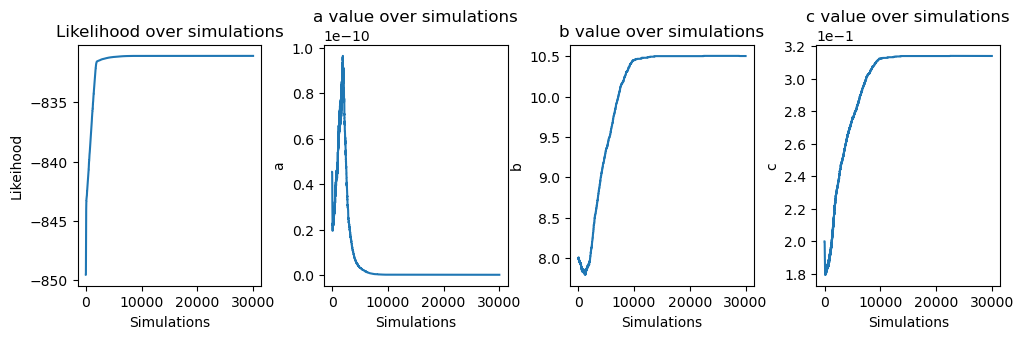

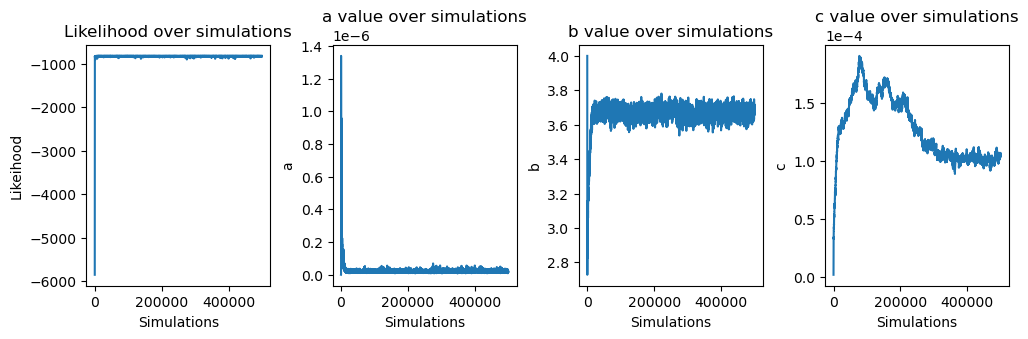

In [32]:
#BMI
finalfuncbmi = mcmc(30000,0.1,8,0.2,0.0001,0.005,0.001,data_2,'bmi',True)

#AGE
finalfuncage = mcmc(500000,1e6,4,2e-6,2e5,0.05,1e-6,data_3,'age',True)



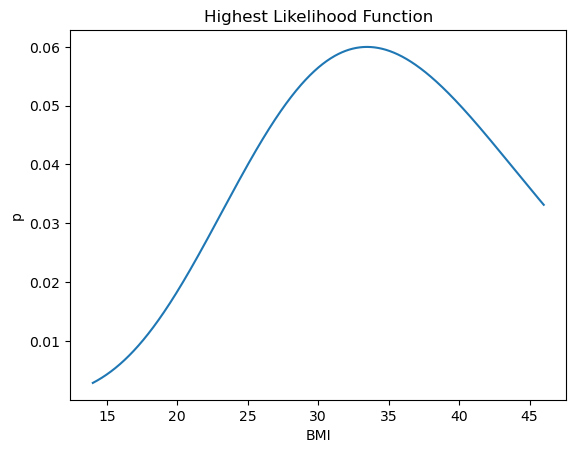

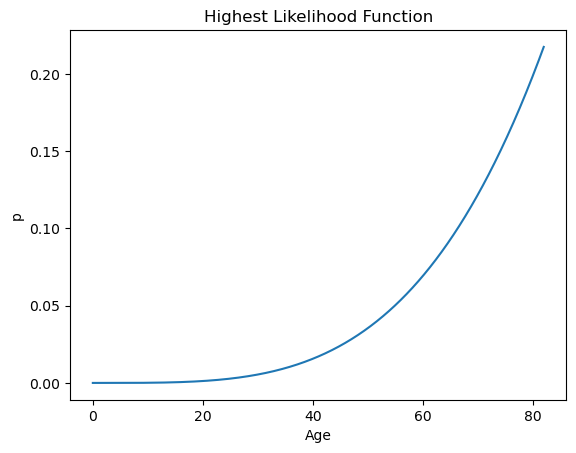

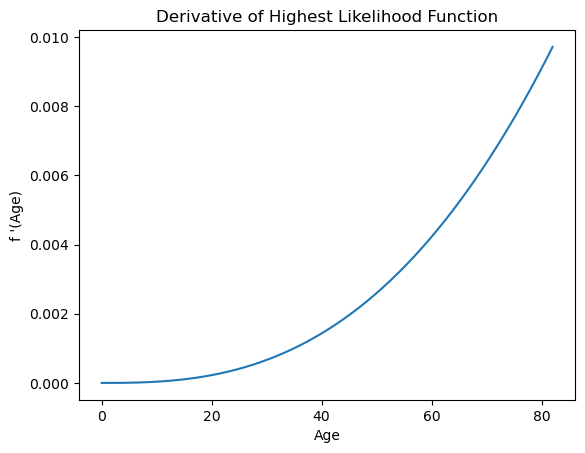

In [33]:
#plotting final functions

bmi4plots = np.linspace(14,46,1000)
age4plots = np.linspace(0,82,1000)

#bmi plot
plt.plot(bmi4plots,finalfuncbmi[0]*np.power(bmi4plots,finalfuncbmi[1])*np.exp(-finalfuncbmi[2]*bmi4plots))
plt.xlabel('BMI')
plt.ylabel('p')
plt.title('Highest Likelihood Function')
plt.show()

#Specific value bmi 32/20
#bmi20 = finalfuncbmi[0]*np.power(20,finalfuncbmi[1])*np.exp(-finalfuncbmi[2]*20)
#bmi32 = finalfuncbmi[0]*np.power(32,finalfuncbmi[1])*np.exp(-finalfuncbmi[2]*32)
#print(bmi32/bmi20)

#age plot
plt.plot(age4plots,finalfuncage[0]*np.power(age4plots,finalfuncage[1])*np.exp(-finalfuncage[2]*age4plots))
plt.xlabel('Age')
plt.ylabel('p')
plt.title('Highest Likelihood Function')
plt.show()

#age derivative plot
plt.plot(age4plots,finalfuncage[0]*np.power(age4plots,finalfuncage[1]-1)*np.exp(-finalfuncage[2]*age4plots)*(finalfuncage[1]-finalfuncage[2]*age4plots))
plt.xlabel('Age')
plt.ylabel("f '(Age)")
plt.title('Derivative of Highest Likelihood Function')
plt.show()

#print peak bmi
# print(finalfuncbmi[1]/finalfuncbmi[2])

#specific derivative value age 60/30
# age = 30
# age20 = finalfuncage[0]*np.power(age,finalfuncage[1]-1)*np.exp(-finalfuncage[2]*age)*(finalfuncage[1]-finalfuncage[2]*age)
# age = 60
# age60 = finalfuncage[0]*np.power(age,finalfuncage[1]-1)*np.exp(-finalfuncage[2]*age)*(finalfuncage[1]-finalfuncage[2]*age)
# print(age60/age20)

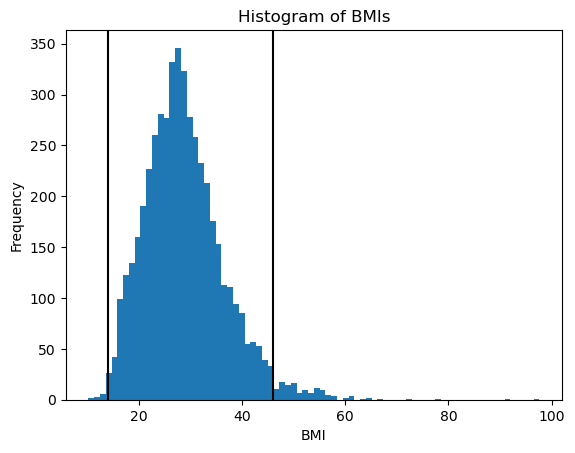

Text(0.5, 1.0, 'Histogram of Ages')

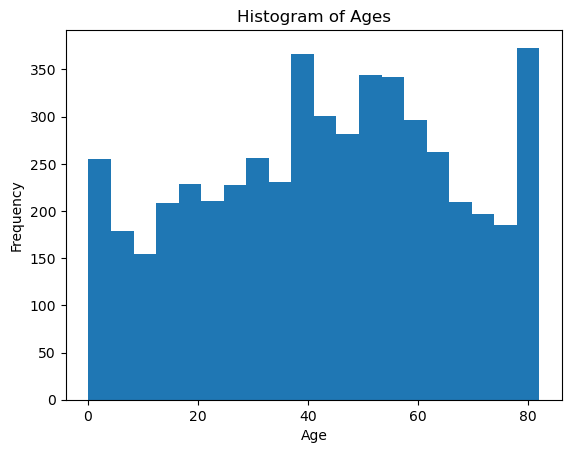

In [34]:
#plot histograms
plt.hist(data['bmi'], bins='auto')
plt.axvline(14,color='black')
plt.axvline(46,color = 'black')
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.title('Histogram of BMIs')
plt.show()
plt.hist(data_3['age'], bins='auto')
plt.ylabel('Frequency')
plt.xlabel('Age')
plt.title('Histogram of Ages')

In [35]:
#print final parameters
print(finalfuncbmi)
print(finalfuncage)

[2.1285650134397113e-13, 10.502375075810283, 0.3138814289887151]
[2.041768390544458e-08, 3.673697634755646, 9.986150326677153e-05]
